In [ ]:
import pandas as pd
import joblib

df = pd.read_csv('/content/drive/MyDrive/IDS/data/combined_dataset.csv')

joblib.dump(df,"/content/drive/MyDrive/IDS/data/netIDS.pkl")

['/content/drive/MyDrive/IDS/data/netIDS.pkl']

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from google.colab import drive

# Mount Google Drive to access datasets and save models
#drive.mount('/content/drive')

# Set paths
data_path = '/content/drive/MyDrive/IDS/data/netIDS.pkl'
model_save_path = '/content/drive/MyDrive/IDS/models/svm_model_tf.keras'
scaler_save_path = '/content/drive/MyDrive/IDS/models/scaler_tf.pkl'

# Load training data (ensure preprocessing is done prior)
df = joblib.load(data_path)
#print("DataFrame columns:", df.columns)
X = df.drop(' Label', axis=1)
y = df[' Label']

X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values (this will also remove corresponding y values)
# We create a combined DataFrame to ensure y is consistent with X after dropping NaNs
combined_df = pd.concat([X, y], axis=1).dropna()

X = combined_df.drop(' Label', axis=1).values
y = combined_df[' Label']

y = y.apply(lambda x: 0 if x == 'BENIGN' else 1)
y = y.values.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build SVM-style model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"[INFO] SVM model accuracy on test data: {accuracy:.4f}")

# Save the scaler
joblib.dump(scaler, scaler_save_path)
model.save(model_save_path)
print(f"[INFO] SVM-style model saved to {model_save_path}")

Epoch 1/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 180s 2ms/step - accuracy: 0.9718 - loss: 0.0665
Epoch 2/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 196s 2ms/step - accuracy: 0.9810 - loss: 0.0432
Epoch 3/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 171s 2ms/step - accuracy: 0.9835 - loss: 0.0383
Epoch 4/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 174s 2ms/step - accuracy: 0.9895 - loss: 0.0280
Epoch 5/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9906 - loss: 0.0254
Epoch 6/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9914 - loss: 0.0231
Epoch 7/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9917 - loss: 0.0227
Epoch 8/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 204s 2ms/step - accuracy: 0.9922 - loss: 0.0219
Epoch 9/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 172s 2ms/step - accuracy: 0.9917 - loss: 0.0227
Epoch 10/10
70697/70697 ━━━━━━━━━━━━━━━━━━━━ 204s 2ms/step - accuracy: 0.9927 - loss: 0.0202
17675/17675 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9935 - loss: 0.0200

17675/17675 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step


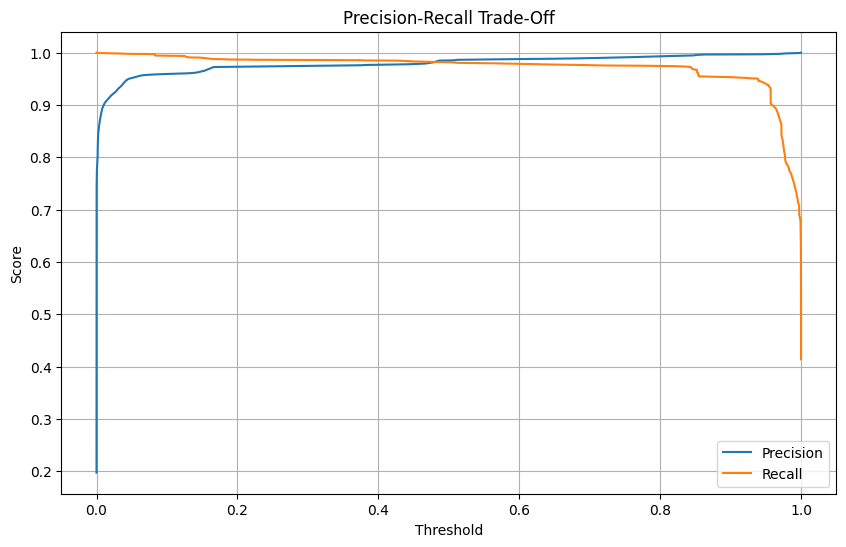

[INFO] Best Threshold: 0.8225
[INFO] Precision: 0.9940
[INFO] Recall: 0.9743
[INFO] F1 Score: 0.9841

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    454089
           1       0.99      0.97      0.98    111487

    accuracy                           0.99    565576
   macro avg       0.99      0.99      0.99    565576
weighted avg       0.99      0.99      0.99    565576



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Predict probabilities from the trained model
y_scores = model.predict(X_test)

# Generate precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision-recall trade-off
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-Off')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print threshold where F1 is maximized
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
print(f"[INFO] Best Threshold: {thresholds[best_idx]:.4f}")
print(f"[INFO] Precision: {precision[best_idx]:.4f}")
print(f"[INFO] Recall: {recall[best_idx]:.4f}")
print(f"[INFO] F1 Score: {f1_scores[best_idx]:.4f}")

# Predict using the best threshold
y_pred = (y_scores > thresholds[best_idx]).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

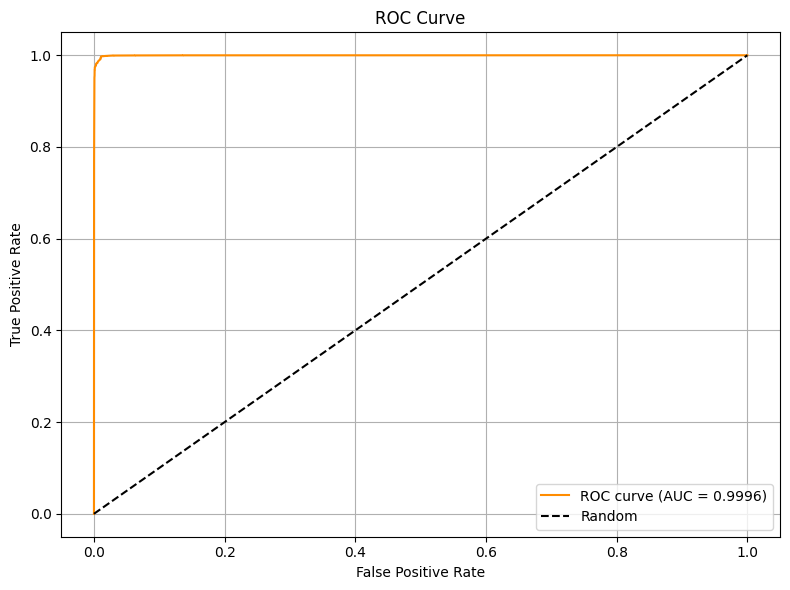

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



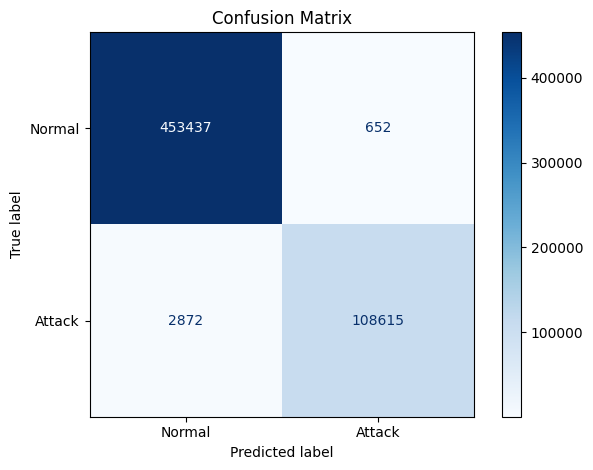

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Apply threshold
threshold = 0.8225
y_pred = (y_scores > threshold).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.grid(False)
plt.show()


In [ ]:
# Uninstall potentially incompatible versions
!pip uninstall scikit-learn scipy -y

# Install compatible versions (latest recommended)
!pip install scikit-learn scipy

# Restart the runtime if prompted

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 24.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

# Set paths
data_path = '/content/drive/MyDrive/IDS/data/netIDS.pkl'
model_save_path = '/content/drive/MyDrive/IDS/models/autoencoder_tf.keras'
scaler_save_path = '/content/drive/MyDrive/IDS/models/ae_scaler_tf.pkl'

# Load training data (only normal samples)
X = joblib.load(data_path)
X = X[X[' Label'] == 'BENIGN']
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
X = X.drop(' Label', axis=1)

# Split for evaluation
X_train, X_test = train_test_split(X, test_size=0.2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build Autoencoder
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=10, batch_size=64)

# Evaluate reconstruction error
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
y_pred = (mse > threshold).astype("int32")

# Assume X_test was all normal (label 0), adjust if labels are available
y_true = np.zeros_like(y_pred)
accuracy = np.mean(y_pred == y_true)
print(f"[INFO] Autoencoder anomaly detection accuracy: {accuracy:.4f}")
print(f"[INFO] Autoencoder detection threshold: {threshold:.4f}")

# Save the scaler
joblib.dump(scaler, scaler_save_path)

# Save Autoencoder
autoencoder.save(model_save_path)
print(f"[INFO] Autoencoder saved to {model_save_path}")


Epoch 1/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 0.0016
Epoch 2/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - loss: 5.9033e-05
Epoch 3/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 5.0343e-05
Epoch 4/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 4.4575e-05
Epoch 5/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 4.2799e-05
Epoch 6/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - loss: 4.2555e-05
Epoch 7/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - loss: 4.2053e-05
Epoch 8/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 80s 2ms/step - loss: 4.1470e-05
Epoch 9/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 81s 2ms/step - loss: 4.1720e-05
Epoch 10/10
28392/28392 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - loss: 4.0940e-05
14196/14196 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step
[INFO] Autoencoder anomaly detection accuracy: 0.9500
[INFO] Autoencoder detection threshold: 0.0001
[INFO] Autoencoder saved to /content/drive/MyDrive/IDS/models/autoencoder_tf.keras


In [ ]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report

def batch_mse(X_true, X_pred, batch_size=1024):
    n = len(X_true)
    errors = []
    for i in range(0, n, batch_size):
        batch_X = X_true[i:i+batch_size]
        batch_pred = X_pred[i:i+batch_size]
        batch_error = np.mean(np.power(batch_X - batch_pred, 2), axis=1)
        errors.extend(batch_error)
    return np.array(errors)

def batch_predict(model, X, batch_size=1024):
    n = len(X)
    predictions = []
    for i in range(0, n, batch_size):
        batch_X = X[i:i+batch_size]
        batch_pred = model.predict(batch_X)
        predictions.append(batch_pred)
    return np.concatenate(predictions, axis=0)

data_path = '/content/drive/MyDrive/IDS/data/netIDS.pkl'
model_save_path = '/content/drive/MyDrive/IDS/models/autoencoder_tf.keras'
scaler_save_path = '/content/drive/MyDrive/IDS/models/ae_scaler_tf.pkl'

full_data = joblib.load(data_path)

# Keep track of the index before dropping NaNs
initial_index = full_data.index

features = full_data.drop(' Label', axis=1)

# Handle infinite and NaN values and keep the index of the valid rows
features = features.replace([np.inf, -np.inf], np.nan)
features_cleaned = features.dropna()
cleaned_index = features_cleaned.index

# Now filter the labels based on the index of the cleaned features
labels = full_data.loc[cleaned_index, ' Label'].values  # Keep original labels for valid rows

# Scale with the same scaler (applied to the cleaned features)
scaler = joblib.load(scaler_save_path)
features_scaled = scaler.transform(features_cleaned)

autoencoder = tf.keras.models.load_model(model_save_path)

reconstructions = batch_predict(autoencoder, features_scaled, batch_size=4096)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
64/64 ━━━━━━━━━━━━━━━━━━━

In [ ]:
def batch_mse(X_true, X_pred, batch_size=1024):
    n = len(X_true)
    errors = []
    for i in range(0, n, batch_size):
        batch_X = X_true[i:i+batch_size]
        batch_pred = X_pred[i:i+batch_size]
        batch_error = np.mean(np.power(batch_X - batch_pred, 2), axis=1)
        errors.extend(batch_error)
    return np.array(errors)

mse = batch_mse(features_scaled, reconstructions)

# You might want to recalculate the threshold based on the full dataset MSE distribution
# or keep the previously calculated threshold if that's the intended behavior.
# For this fix, we assume you use the threshold derived from the distribution
# across all *cleaned* data points. If you need the threshold derived only from
# the training data's normal samples, load it from the previous section or save it.
# For consistency with the problematic code, we re-calculate based on the evaluation set MSE.
threshold = np.percentile(mse[labels == 'BENIGN'], 95) # Recalculate based on benign samples in the cleaned evaluation data

y_pred = (mse > threshold).astype("int32")

# Convert the filtered true labels to numerical
y_true = np.where(labels == 'BENIGN', 0, 1)

# Now evaluate using actual labels (both y_true and y_pred should have the same length)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

NameError: name 'features_scaled' is not defined

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np
import joblib

# Set paths
data_path = '/content/drive/MyDrive/IDS/data/netIDS.pkl'

X = joblib.load(data_path)
X = X[X[' Label'] == 'BENIGN']
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
X = X.drop(' Label', axis=1)

# Split for evaluation
X_train, X_test = train_test_split(X, test_size=0.2)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_scaled = pd.DataFrame(X_train_scaled)
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
count,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,...,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06,1.817056e+06
mean,2.397317e+01,2.466808e+01,4.114853e+00,9.559011e+00,3.847865e+00,5.338519e+01,3.230661e+00,4.201034e-01,6.550034e-01,3.405340e+00,...,2.530801e+00,-2.865147e+02,7.654423e+04,4.635046e+04,1.622218e+05,5.110316e+04,3.745742e+06,2.620347e+05,3.938870e+06,3.513743e+06
std,5.068415e+01,6.642602e+01,3.999852e+02,1.061567e+03,7.722593e+01,7.417132e+03,1.343125e+01,1.587052e+00,4.544391e+00,1.421611e+01,...,3.426901e+02,1.018389e+05,6.485346e+05,4.039113e+05,1.076082e+06,5.712003e+05,1.348707e+07,2.986342e+06,1.411095e+07,1.319321e+07
min,-2.051282e-01,-6.842033e-02,-5.000000e-01,-2.000000e+00,-4.459459e-01,-3.963415e-01,-6.779661e-01,-1.500000e-01,-8.222222e-01,0.000000e+00,...,-5.000000e-01,-4.473922e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-6.923077e-02,-6.800995e-02,0.000000e+00,-1.000000e+00,-3.648649e-01,-3.841463e-01,-5.762712e-01,-1.500000e-01,-6.888889e-01,0.000000e+00,...,-5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.307692e-01,9.319900e-01,1.000000e+00,0.000000e+00,6.351351e-01,6.158537e-01,4.237288e-01,8.500000e-01,3.111111e-01,1.000000e+00,...,5.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.678333e+02,2.646905e+02,1.098785e+05,2.919200e+05,8.716172e+04,1.998332e+06,4.200000e+02,5.797500e+01,1.030000e+02,3.053171e+02,...,1.067780e+05,9.833333e+00,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [ ]:
print(threshold)

nan


In [ ]:
X_train.describe()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,...,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06,2.271320e+06
mean,2.391023e+01,2.460007e+01,4.330658e+00,1.014776e+01,3.851522e+00,5.711418e+01,3.229814e+00,4.201785e-01,6.542732e-01,3.403798e+00,...,2.683042e+00,-2.869760e+02,7.645656e+04,4.651253e+04,1.623768e+05,5.091346e+04,3.748898e+06,2.605746e+05,3.941006e+06,3.517911e+06
std,5.062438e+01,6.619412e+01,4.184314e+02,1.113424e+03,7.187996e+01,7.702433e+03,1.341787e+01,1.584442e+00,4.540546e+00,1.420557e+01,...,3.552275e+02,1.009381e+05,6.385961e+05,4.079090e+05,1.074708e+06,5.585501e+05,1.349617e+07,2.975802e+06,1.411598e+07,1.320417e+07
min,-2.051282e-01,-6.813315e-02,-5.000000e-01,-2.000000e+00,-4.459459e-01,-3.963415e-01,-6.779661e-01,-1.500000e-01,-8.222222e-01,0.000000e+00,...,-5.000000e-01,-4.473922e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,-6.923077e-02,-6.772237e-02,0.000000e+00,-1.000000e+00,-3.648649e-01,-3.841463e-01,-5.762712e-01,-1.500000e-01,-6.888889e-01,0.000000e+00,...,-5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.307692e-01,9.322776e-01,1.000000e+00,0.000000e+00,6.351351e-01,6.158537e-01,4.237288e-01,8.500000e-01,3.111111e-01,1.000000e+00,...,5.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.678333e+02,2.635371e+02,1.098785e+05,2.919200e+05,8.716172e+04,1.998332e+06,4.200000e+02,5.797500e+01,1.030000e+02,3.250682e+02,...,1.067780e+05,9.833333e+00,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


from matplotlib import pyplot as plt
_df_0[' Destination Port'].plot(kind='hist', bins=20, title=' Destination Port')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[' Flow Duration'].plot(kind='hist', bins=20, title=' Flow Duration')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2[' Total Fwd Packets'].plot(kind='hist', bins=20, title=' Total Fwd Packets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3[' Total Backward Packets'].plot(kind='hist', bins=20, title=' Total Backward Packets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x=' Destination Port', y=' Flow Duration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x=' Flow Duration', y=' Total Fwd Packets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x=' Total Fwd Packets', y=' Total Backward Packets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x=' Total Backward Packets', y='Total Length of Fwd Packets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9[' Destination Port'].plot(kind='line', figsize=(8, 4), title=' Destination Port')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10[' Flow Duration'].plot(kind='line', figsize=(8, 4), title=' Flow Duration')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11[' Total Fwd Packets'].plot(kind='line', figsize=(8, 4), title=' Total Fwd Packets')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12[' Total Backward Packets'].plot(kind='line', figsize=(8, 4), title=' Total Backward Packets')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x=' Destination Port', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x=' Flow Duration', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x=' Total Fwd Packets', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x=' Total Backward Packets', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

ERROR:root:Did not find quickchart key chart-3944802c-7713-49ad-82d2-409c29e1a514 in chart cache


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

def batch_mse(X_true, X_pred, batch_size=1024):
    n = len(X_true)
    errors = []
    for i in range(0, n, batch_size):
        batch_X = X_true[i:i+batch_size]
        batch_pred = X_pred[i:i+batch_size]
        batch_error = np.mean(np.power(batch_X - batch_pred, 2), axis=1)
        errors.extend(batch_error)
    return np.array(errors)

data_path_csv = '/content/drive/MyDrive/IDS/data/combined_dataset.csv' # Path to the original CSV
scaler_save_path = '/content/drive/MyDrive/IDS/models/scaler_tf.pkl'
model_save_path = '/content/drive/MyDrive/IDS/models/autoencoder_tf.keras'

df_eval = pd.read_csv(data_path_csv)

# Handle infinite and NaN values
df_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
df_eval.dropna(inplace=True)

# Separate features and labels for evaluation
X_eval = df_eval.drop(' Label', axis=1)
y_eval_labels = df_eval[' Label']

scaler = joblib.load(scaler_save_path)

# Use the same scaler fitted on the training data from the SVM section
# This ensures consistency in preprocessing
X_eval_scaled = scaler.transform(X_eval)

autoencoder = load_model(model_save_path)

# Get reconstruction errors for the evaluation data
reconstructions_eval = autoencoder.predict(X_eval_scaled)
mse_eval = batch_mse(X_eval_scaled, reconstructions_eval)

# Convert true labels to numerical (0 for BENIGN, 1 for ATTACK)
# This is the 'true_labels' variable that was missing
true_labels = y_eval_labels.apply(lambda x: 0 if x == 'BENIGN' else 1).values

mse_benign_eval = mse_eval[true_labels == 0]
threshold = np.percentile(mse_benign_eval, 95)

y_pred_ae = (mse_eval > threshold).astype("int32")

accuracy_ae = np.mean(y_pred_ae == true_labels)
print(f"[INFO] Autoencoder anomaly detection accuracy on evaluation data: {accuracy_ae:.4f}")
print(f"[INFO] Autoencoder detection threshold: {threshold:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


88372/88372 ━━━━━━━━━━━━━━━━━━━━ 149s 2ms/step
[INFO] Autoencoder anomaly detection accuracy on evaluation data: 0.8572
[INFO] Autoencoder detection threshold: 0.2967


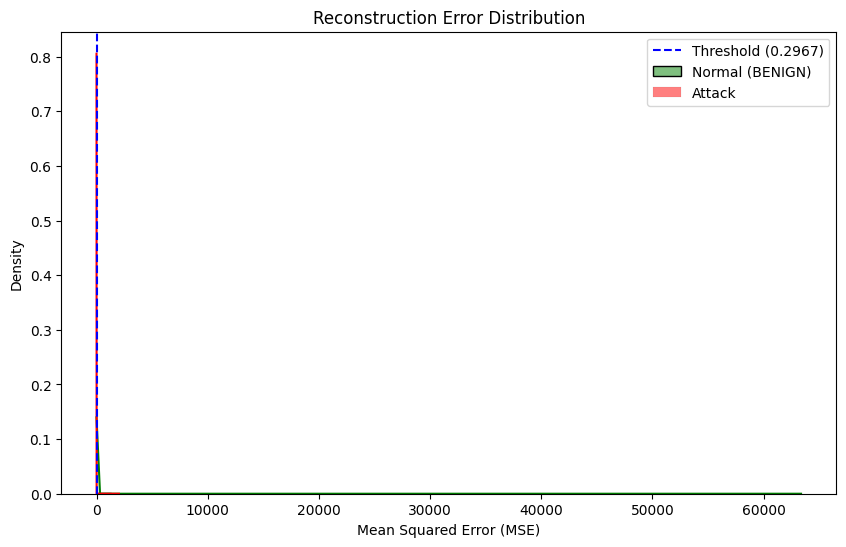

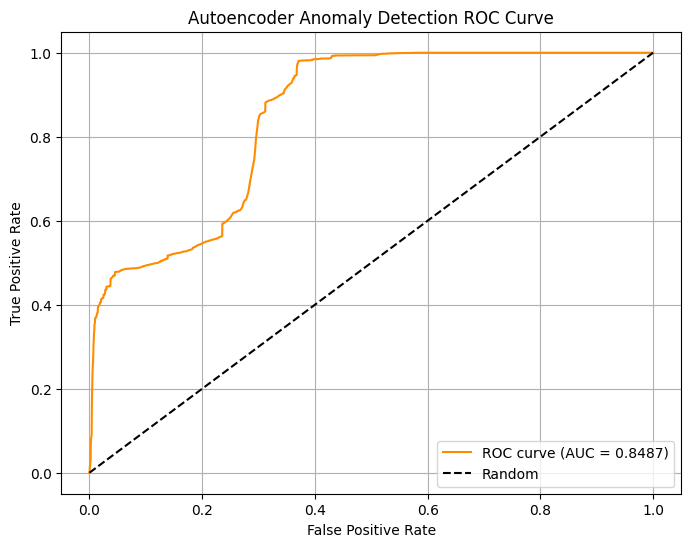

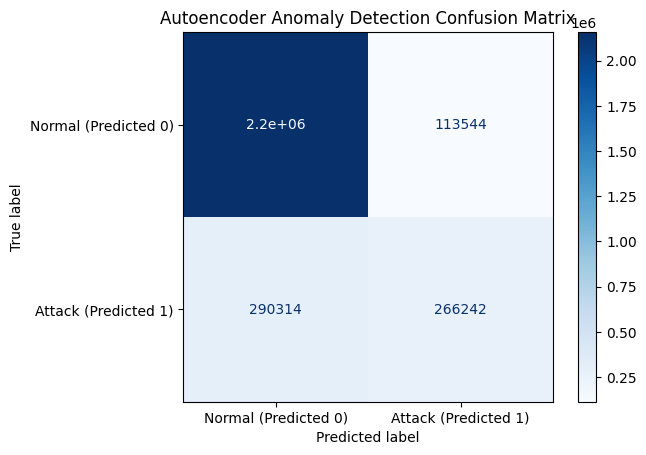

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(10, 6))
sns.histplot(mse_eval[true_labels == 0], bins=50, color='green', label='Normal (BENIGN)', kde=True, stat='density', common_norm=False)
sns.histplot(mse_eval[true_labels == 1], bins=50, color='red', label='Attack', kde=True, stat='density', common_norm=False)
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Density")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(true_labels, mse_eval) # ROC curve uses true labels and anomaly score (MSE)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("Autoencoder Anomaly Detection ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred_ae)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (Predicted 0)", "Attack (Predicted 1)"])
disp.plot(cmap="Blues")
plt.title("Autoencoder Anomaly Detection Confusion Matrix")
plt.grid(False) # Turn off grid for Confusion Matrix display
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

data_path_csv = '/content/drive/MyDrive/IDS/data/combined_dataset.csv' # Path to the original CSV
model_save_path = '/content/drive/MyDrive/IDS/models/autoencoder_tf.keras'
scaler_save_path = '/content/drive/MyDrive/IDS/models/scaler_tf.pkl'

df_eval = pd.read_csv(data_path_csv)

# Handle infinite and NaN values
df_eval.replace([np.inf, -np.inf], np.nan, inplace=True)
df_eval.dropna(inplace=True)

# Separate features and labels for evaluation
X_eval = df_eval.drop(' Label', axis=1)
y_eval_labels = df_eval[' Label']

scaler = joblib.load(scaler_save_path)

# Use the same scaler fitted on the training data from the SVM section
# This ensures consistency in preprocessing
X_eval_scaled = scaler.transform(X_eval)

true_labels = y_eval_labels.apply(lambda x: 0 if x == 'BENIGN' else 1).values

X_val, X_test, y_val, y_test = train_test_split(
    X_eval_scaled, true_labels, test_size=0.5, random_state=42
)

def batch_mse(X_true, X_pred, batch_size=1024):
    n = len(X_true)
    errors = []
    for i in range(0, n, batch_size):
        batch_X = X_true[i:i+batch_size]
        batch_pred = X_pred[i:i+batch_size]
        batch_error = np.mean(np.power(batch_X - batch_pred, 2), axis=1)
        errors.extend(batch_error)
    return np.array(errors)

def calculate_reconstruction_errors(model, X):
    """Returns reconstruction error (MSE) per sample."""
    reconstructed = model.predict(X)
    return batch_mse(X, reconstructed)

def find_best_threshold(recon_errors, true_labels):
    """Finds the best threshold based on F1-score."""
    best_threshold = 0
    best_f1 = 0
    thresholds = np.linspace(min(recon_errors), max(recon_errors), 200)

    for t in thresholds:
        preds = (recon_errors > t).astype(int)
        f1 = f1_score(true_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Best F1 Score: {best_f1:.4f}")
    return best_threshold

# === Example usage (assuming you have model, X_val, y_val) ===

# 1. Get reconstruction errors
autoencoder = load_model(model_save_path)
val_errors = calculate_reconstruction_errors(autoencoder, X_val)

# 2. Find best threshold
best_thresh = find_best_threshold(val_errors, y_val)

# 3. Apply threshold to test data
test_errors = calculate_reconstruction_errors(autoencoder, X_test)
y_pred = (test_errors > best_thresh).astype(int)

# 4. Print final evaluation
print("\nFinal Evaluation on Test Set:")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
print(f"AUC:       {roc_auc_score(y_test, test_errors):.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


44186/44186 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step
Best Threshold: 0.0010
Best F1 Score: 0.3285
44186/44186 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step

Final Evaluation on Test Set:
Precision: 0.1971
Recall:    1.0000
F1 Score:  0.3292
AUC:       0.8490


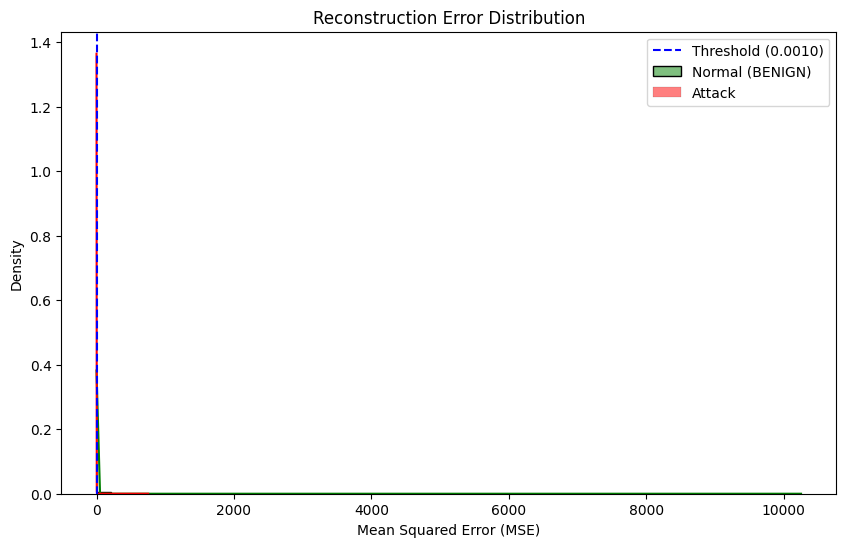

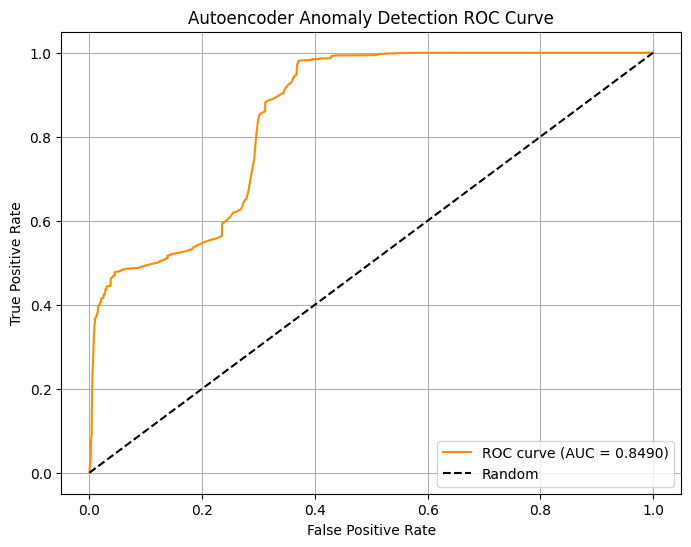

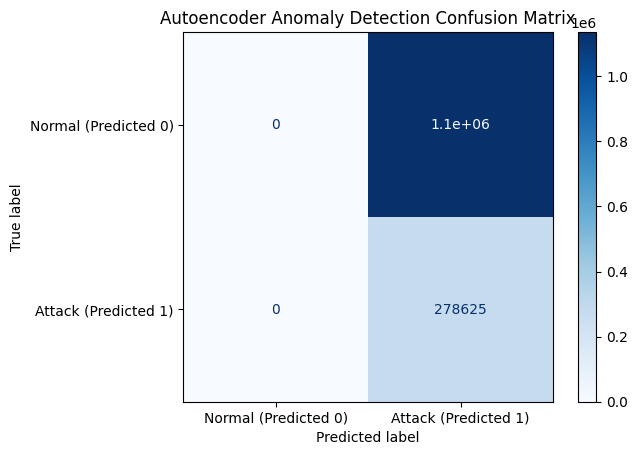

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

plt.figure(figsize=(10, 6))
sns.histplot(test_errors[y_test == 0], bins=50, color='green', label='Normal (BENIGN)', kde=True, stat='density', common_norm=False)
sns.histplot(test_errors[y_test == 1], bins=50, color='red', label='Attack', kde=True, stat='density', common_norm=False)
plt.axvline(best_thresh, color='blue', linestyle='--', label=f'Threshold ({best_thresh:.4f})')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error (MSE)")
plt.ylabel("Density")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_errors) # ROC curve uses true labels and anomaly score (MSE)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("Autoencoder Anomaly Detection ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (Predicted 0)", "Attack (Predicted 1)"])
disp.plot(cmap="Blues")
plt.title("Autoencoder Anomaly Detection Confusion Matrix")
plt.grid(False) # Turn off grid for Confusion Matrix display
plt.show()

In [ ]:
import numpy as np

accuracy = np.mean(y_pred == test_errors)
print(f"[INFO] Autoencoder model accuracy on test data: {accuracy:.4f}")

[INFO] Autoencoder model accuracy on test data: 0.0000


In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, val_errors)
target_recall = 0.95

for p, r, t in zip(precisions, recalls, thresholds):
    if r >= target_recall:
        print(f"Threshold: {t:.4f}, Precision: {p:.4f}, Recall: {r:.4f}")
        break


Threshold: 0.0010, Precision: 0.1966, Recall: 1.0000


In [6]:
import pandas as pd
import joblib

def clean_attack_labels(df, label_column=' Label'):
    """
    Clean and standardize attack labels in the given DataFrame.

    Parameters:
        df (pd.DataFrame): Your dataset.
        label_column (str): Name of the column containing the labels.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """

    # Define label normalization mapping
    label_map = {
        'benign': 'BENIGN',
        'bot': 'Bot',
        'ddos': 'DDoS',
        'dos goldeneye': 'DoS GoldenEye',
        'dos hulk': 'DoS Hulk',
        'dos slowhttptest': 'DoS Slowhttptest',
        'dos slowloris': 'DoS Slowloris',
        'ftp-patator': 'FTP-Patator',
        'heartbleed': 'Heartbleed',
        'infiltration': 'Infiltration',
        'portscan': 'PortScan',
        'ssh-patator': 'SSH-Patator',
        'web attack - brute force': 'Web Attack – Brute Force',
        'web attack – brute force': 'Web Attack – Brute Force',
        'web attack - xss': 'Web Attack – XSS',
        'web attack – xss': 'Web Attack – XSS',
        'web attack - sql injection': 'Web Attack – Sql Injection',
        'web attack – sql injection': 'Web Attack – Sql Injection'
    }

    # Step 1: Normalize encoding characters and trim spaces
    df[label_column] = (
        df[label_column]
        .astype(str)
        .str.strip()
        .str.replace('�', '-', regex=False)  # Replace encoding issues
        .str.lower()
    )

    # Step 2: Map to cleaned labels
    df[label_column] = df[label_column].map(label_map)

    # Step 3: Drop rows with unknown or unmapped labels
    df = df.dropna(subset=[label_column])

    return df

df = pd.read_csv('/content/drive/MyDrive/IDS/data/combined_dataset.csv', encoding='utf-8')

df = clean_attack_labels(df, label_column=' Label')  # or 'label', depending on your column name

df.to_csv('/content/drive/MyDrive/IDS/data/cleaned_dataset.csv', index=False, encoding='utf-8')

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# === 1. Load Data ===
data = pd.read_csv('/content/drive/MyDrive/IDS/data/cleaned_dataset.csv')  # Adjust path
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# === 2. Encode Labels ===
labels = data[' Label']
le = LabelEncoder()
y = le.fit_transform(labels)  # e.g., DoS, PortScan, Benign, etc.

# === 3. Drop Label & Scale Features ===
X = data.drop(' Label', axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 4. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# === 5. Train XGBoost ===
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # or 'multi:softprob' for probabilities
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_test,y_test)],
              sample_weight=sample_weights)

# === 6. Predict & Evaluate ===
y_pred = xgb_model.predict(X_test)
print("[INFO] Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\n[INFO] Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# === 7. Save Model & LabelEncoder ===
joblib.dump(xgb_model, '/content/drive/MyDrive/IDS/models/xgb_model.pkl')
joblib.dump(le, '/content/drive/MyDrive/IDS/models/xgb_label_encoder.pkl')


[0]	validation_0-mlogloss:2.18169
[1]	validation_0-mlogloss:1.84179
[2]	validation_0-mlogloss:1.63274
[3]	validation_0-mlogloss:1.42879
[4]	validation_0-mlogloss:1.25750
[5]	validation_0-mlogloss:1.12062
[6]	validation_0-mlogloss:1.00587
[7]	validation_0-mlogloss:0.90852
[8]	validation_0-mlogloss:0.82294
[9]	validation_0-mlogloss:0.74857
[10]	validation_0-mlogloss:0.68188
[11]	validation_0-mlogloss:0.62259
[12]	validation_0-mlogloss:0.57026
[13]	validation_0-mlogloss:0.52331
[14]	validation_0-mlogloss:0.48146
[15]	validation_0-mlogloss:0.44374
[16]	validation_0-mlogloss:0.41006
[17]	validation_0-mlogloss:0.37969
[18]	validation_0-mlogloss:0.35252
[19]	validation_0-mlogloss:0.32411
[20]	validation_0-mlogloss:0.30109
[21]	validation_0-mlogloss:0.27726
[22]	validation_0-mlogloss:0.25514
[23]	validation_0-mlogloss:0.23619
[24]	validation_0-mlogloss:0.21886
[25]	validation_0-mlogloss:0.20268
[26]	validation_0-mlogloss:0.18817
[27]	validation_0-mlogloss:0.17455
[28]	validation_0-mlogloss:0.1

['/content/drive/MyDrive/IDS/models/xgb_label_encoder.pkl']

In [1]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np
import pandas as pd

data_path = '/content/drive/MyDrive/IDS/data/netIDS.pkl'
X = joblib.load(data_path)
X = X[X[' Label'] == 'BENIGN']
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
X = X.drop(' Label', axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, '/content/drive/MyDrive/IDS/models/scaler.pkl')

['/content/drive/MyDrive/IDS/models/scaler.pkl']